## 1. Defining the Question(s)

### Central Goal  
Can we build and evaluate a machine learning model that accurately predict the outcome of a men's international football match (Home Win, Draw, or Away Win) using historical match data?

### Secondary Questions  
- What features matter most for predicting match outcomes? (e.g., recent form, historical dominance, home-field advantage)  
- Does model performance change across tournament types (World Cup vs. friendlies)?  
- Does the model show any bias, such as favoring top-ranked teams over underdogs?

### Import necessary Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


### Load the Datasets

In [3]:
results = pd.read_csv('data/results.csv')
goalscorers = pd.read_csv('data/goalscorers.csv')
shootouts = pd.read_csv('data/shootouts.csv')
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


### Data Cleaning

In [4]:
# Date and year extracted from date column
results['date'] = pd.to_datetime(results['date'])
results['year'] = results['date'].dt.year

# Determine match outcome by comparing scores
def get_outcome(row):
    if row['home_score'] > row['away_score']:
        return "Home Win"
    elif row['away_score'] > row['home_score']:
        return "Away Win"
    else:
        return "Draw"
# Convert False to 0 and True to 1 on neutral column
def is_neutral(row):
    if row['neutral']:
        return 1
    else:
        return 0
        
results['outcome'] = results.apply(get_outcome, axis=1)
results['neutral'] = results.apply(is_neutral, axis=1)

print(results.tail(10))
print(results.info())

            date              home_team               away_team  home_score  \
48840 2025-11-18                Austria  Bosnia and Herzegovina         1.0   
48841 2025-11-18                Romania              San Marino         7.0   
48842 2025-11-18                  Wales         North Macedonia         7.0   
48843 2025-11-18                Belgium           Liechtenstein         7.0   
48844 2025-11-18     Dominican Republic              Martinique         0.0   
48845 2025-11-18  Saint Kitts and Nevis                  Belize         2.0   
48846 2025-11-18    Antigua and Barbuda                  Guyana         1.0   
48847 2025-11-18                   Iran              Uzbekistan         0.0   
48848 2025-11-19                   Laos                 Vietnam         0.0   
48849 2025-11-20                Vanuatu         Solomon Islands         NaN   

       away_score                    tournament                        city  \
48840         1.0  FIFA World Cup qualification    

In [5]:
# Nummer of missing values in each column
# Function to filter games played by a particular team and game date
def filter_games_by_team(team_name, game_date):
    return results[(results["home_team"] == team_name) & (results["date"] < game_date)]
        
# Function to allocate points to Home team for win, lost or draw
def get_home_team_points_from_outcome(outcome):
    if outcome == 'Home Win':
        return 3
    elif outcome == 'Away Win':
        return 0
    else:
        return 1

# Function to allocate points to Away team for win, lost or draw
def get_away_team_points_from_outcome(outcome):
    if outcome == 'Away Win':
        return 3
    elif outcome == 'Home Win':
        return 0
    else:
        return 1

# Function to calculate average scores based on certain metrics
def calculate_rolling_form_metrics(row): 
    N = 10
    # Create data frame based on filtered criteria
    home_team_history = filter_games_by_team(row["home_team"], row["date"]).tail(N)
    away_team_history = filter_games_by_team(row["away_team"], row["date"]).tail(N)
    
    avg_goals_scored_home_team = home_team_history['home_score'].mean()
    if math.isnan(avg_goals_scored_home_team):
        avg_goals_scored_home_team = 0
    avg_goals_conceded_home_team = home_team_history['away_score'].mean()
    if math.isnan(avg_goals_conceded_home_team):
        avg_goals_conceded_home_team = 0
    avg_points_home_team = home_team_history['outcome'].map(get_home_team_points_from_outcome).mean()
    if math.isnan (avg_points_home_team):
        avg_points_home_team = 0
     
    avg_goals_scored_away_team = away_team_history['away_score'].mean()
    if math.isnan(avg_goals_scored_away_team):
        avg_goals_scored_away_team = 0
    avg_goals_conceded_away_team = away_team_history['home_score'].mean()
    if math.isnan(avg_goals_conceded_away_team):
        avg_goals_scored_home_team = 0
    avg_points_away_team = away_team_history['outcome'].map(get_away_team_points_from_outcome).mean()
    if math.isnan(avg_points_away_team):
        avg_points_away_team = 0
    
    return [
        avg_goals_scored_home_team,     
        avg_goals_conceded_home_team, 
        avg_points_home_team, 
        avg_goals_scored_away_team, 
        avg_goals_conceded_away_team, 
        avg_points_away_team
    ]
    
rolling_form_columns = [
    'avg_goals_scored_home_team',
    'avg_goals_conceded_home_team',
    'avg_points_home_team',
    'avg_goals_scored_away_team',
    'avg_goals_conceded_away_team',
    'avg_points_away_team'
]
results[rolling_form_columns] = results.apply(calculate_rolling_form_metrics, axis=1, result_type='expand')

print(results.head())

        date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England         0.0         0.0   Friendly  Glasgow   
1 1873-03-08   England  Scotland         4.0         2.0   Friendly   London   
2 1874-03-07  Scotland   England         2.0         1.0   Friendly  Glasgow   
3 1875-03-06   England  Scotland         2.0         2.0   Friendly   London   
4 1876-03-04  Scotland   England         3.0         0.0   Friendly  Glasgow   

    country  neutral  year   outcome  avg_goals_scored_home_team  \
0  Scotland        0  1872      Draw                         0.0   
1   England        0  1873  Home Win                         0.0   
2  Scotland        0  1874  Home Win                         0.0   
3   England        0  1875      Draw                         4.0   
4  Scotland        0  1876  Home Win                         1.0   

   avg_goals_conceded_home_team  avg_points_home_team  \
0                           0.0                   0.0

In [6]:
print(results.tail(10).describe().to_string())

                      date  home_score  away_score    neutral    year  avg_goals_scored_home_team  avg_goals_conceded_home_team  avg_points_home_team  avg_goals_scored_away_team  avg_goals_conceded_away_team  avg_points_away_team
count                   10    9.000000    9.000000  10.000000    10.0                   10.000000                      10.00000             10.000000                   10.000000                     10.000000             10.000000
mean   2025-11-18 07:12:00    2.777778    1.666667   0.200000  2025.0                    1.830000                       1.16000              1.730000                    1.440000                      1.480000              1.260000
min    2025-11-18 00:00:00    0.000000    0.000000   0.000000  2025.0                    0.700000                       0.40000              0.400000                    0.300000                      0.200000              0.400000
25%    2025-11-18 00:00:00    0.000000    0.000000   0.000000  2025.0           

In [7]:
# Function to calculate home team's win pct against a particular away team
def calculate_h2h_home_win_pct(row):
    past_matches = results[
        (results['home_team'] == row['home_team']) &
        (results['away_team'] == row['away_team']) &
        (results['date'] < row['date'])
    ]
    if len(past_matches) > 0:
        home_wins = sum(past_matches['outcome'] == 'Home Win')
        return home_wins / len(past_matches)
    else:
        return 0.50

results['h2h_home_win_pct'] = results.apply(calculate_h2h_home_win_pct, axis=1)

results["goal_difference_form"] = (
    results["avg_goals_scored_home_team"] - results["avg_goals_scored_away_team"]
)

results["points_difference_form"] = (
    results["avg_points_home_team"] - results["avg_points_away_team"]
)


In [8]:
print(results['h2h_home_win_pct'])
print(results['goal_difference_form'])

0        0.500000
1        0.500000
2        0.000000
3        1.000000
4        0.500000
           ...   
48845    0.000000
48846    0.857143
48847    0.500000
48848    0.000000
48849    0.375000
Name: h2h_home_win_pct, Length: 48850, dtype: float64
0        0.0
1        0.0
2       -2.0
3        3.5
4       -1.0
        ... 
48845    0.3
48846   -1.0
48847    1.8
48848    0.2
48849   -0.2
Name: goal_difference_form, Length: 48850, dtype: float64


### Data Analysis

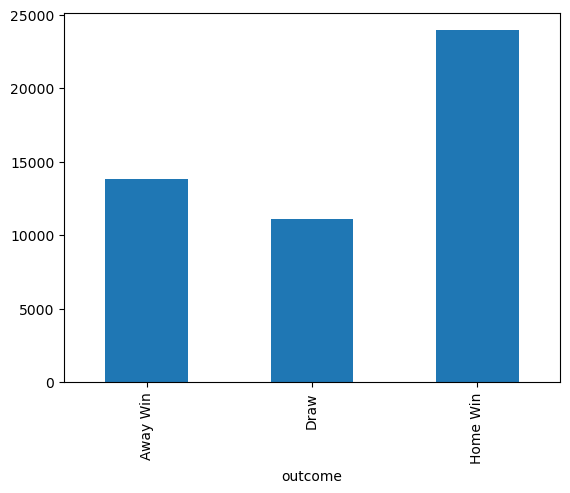

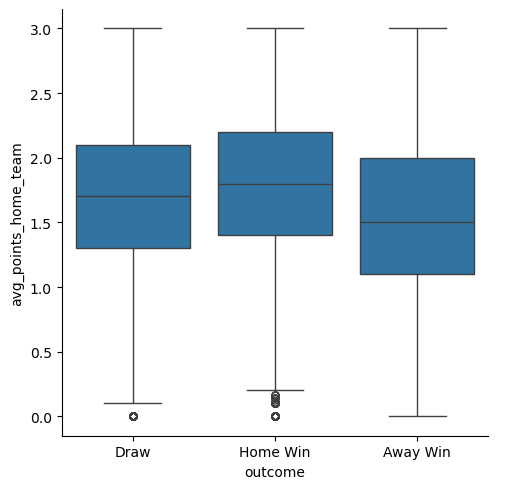

In [9]:
results.groupby('outcome')['outcome'].count().plot(kind='bar')

plt.show()

sns.catplot(x='outcome',
           y='avg_points_home_team',
           data=results,
           kind='box')

plt.show()

In [10]:
TRAINING_SPLIT_CUTOFF_PERCENT = 80
count = results['outcome'].count()
training_split_cutoff = math.trunc(TRAINING_SPLIT_CUTOFF_PERCENT * count / 100)

test_count = count - training_split_cutoff

training_set = results.head(training_split_cutoff)
test_set = results.tail(test_count)

print(training_set.info())
print(test_set.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39080 entries, 0 to 39079
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          39080 non-null  datetime64[ns]
 1   home_team                     39080 non-null  object        
 2   away_team                     39080 non-null  object        
 3   home_score                    39080 non-null  float64       
 4   away_score                    39080 non-null  float64       
 5   tournament                    39080 non-null  object        
 6   city                          39080 non-null  object        
 7   country                       39080 non-null  object        
 8   neutral                       39080 non-null  int64         
 9   year                          39080 non-null  int32         
 10  outcome                       39080 non-null  object        
 11  avg_goals_scored_home_team  